In [1]:
using Images
using PyPlot

In [2]:
# Create a Gaussian filter
function makegaussianfilter(size::Array{Int,2},sigma::Float64)

  # (Squared) distance matrix
  rx = (size[2]-1)/2
  ry = (size[1]-1)/2
  dx = (-rx:rx)'
  dy = -ry:ry
  D = dy.^2 .+ dx.^2

  # (unnormalized) filter weights
  G = exp.(-0.5.*D./sigma^2)

  # normalize
  f = G./sum(G)

  return f::Array{Float64,2}
end


# Create a binomial filter
function makebinomialfilter(size::Array{Int,2})

  # Local function to compute binomial filter entries
  function binomialfactors(n)
    a = [binomial(n-1,i) for i = 0:n-1]
    return a
  end

  # Unnormalized filter weights
  bx = binomialfactors(size[2])'
  by = binomialfactors(size[1])
  B = by*bx

  # normalize
  f = B./sum(B)
  return f::Array{Float64,2}
end


# Downsample an image by a factor of 2
function downsample2(A::Array{Float64,2})
  # Starts with index 1
  D = A[1:2:end,1:2:end]::Array{Float64,2}

  # In principle, also possible:
  # For odd/even length we could start with index 1/2, respectively,
  # leading to the behavior of Matlab's imresize(... 'nearest')
  return D::Array{Float64,2}
end


# Upsample an image by a factor of 2
function upsample2(A::Array{Float64,2},fsize::Array{Int,2})

  # Naively replace every other row/col
  hires = zeros(2*size(A,1),2*size(A,2))
  hires[1:2:end,1:2:end] = A

  # Binomial filter and weight correction
  bfilt = makebinomialfilter(fsize)
  U = 4*imfilter(hires,centered(bfilt),"symmetric")

  return U::Array{Float64,2}
end


# Build a Gaussian pyramid from an image.
# The output array should contain the pyramid levels in decreasing sizes.
function makegaussianpyramid(im::Array{Float32,2},nlevels::Int,fsize::Array{Int,2},sigma::Float64)

  # create Gaussian filter
  gfilt = makegaussianfilter(fsize,sigma)

  # Store the resulting pyramid in this array
  G = Array{Array{Float64,2},1}(undef, nlevels)

  #  Start from the finest resolution..
  G[1] = im
  for i = 2:nlevels
    G[i] = downsample2(imfilter(G[i-1], centered(gfilt), "symmetric"))
  end

  return G::Array{Array{Float64,2},1}
end


# Display a given image pyramid (Laplacian or Gaussian)
function displaypyramid(P::Array{Array{Float64,2},1})

  # normalize for display aka 'imagesc'
  function normalize(A)
    return (A .- minimum(A))./(maximum(A).-minimum(A))
  end

  # normalize first image
  img = normalize(P[1])

  # Subsequently normalize consecutive levels and add them
  for i = 2:length(P)
    img = [img [normalize(P[i]); zeros(size(img,1)-size(P[i],1),size(P[i],2))]]
  end

  # show image (without interpolation)
  figure()
  imshow(img,"gray",interpolation="none")
  axis("off")

  return nothing
end


# Build a Laplacian pyramid from a Gaussian pyramid
function makelaplacianpyramid(G::Array{Array{Float64,2},1},nlevels::Int,fsize::Array{Int,2})

  # Store the resulting pyramid in this array
  L = Array{Array{Float64,2},1}(undef, nlevels)

  # The coarsest level of the Laplacian is initialized from the Gaussian pyramid
  L[end] = G[end]

  # Start from the coarsest resolution..
  for i = nlevels-1:-1:1
    L[i] = G[i]- upsample2(G[i+1],fsize)
  end

  return L::Array{Array{Float64,2},1}
end


reconstructlaplacianpyramid (generic function with 1 method)

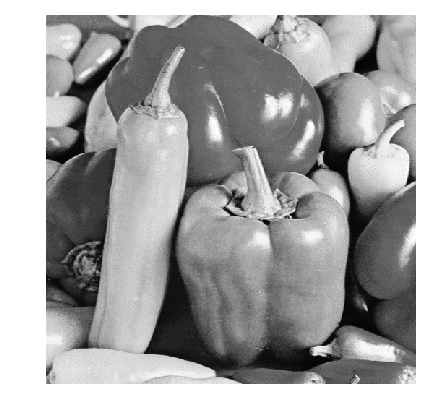

(PyObject <matplotlib.image.AxesImage object at 0x00000000010D8EB8>, (-0.5, 511.5, 511.5, -0.5))

In [3]:
# Problem 1: Image Pyramids and Image Sharpening

# load image
im = PyPlot.imread("../data-julia/a2p1.png")
imshow(im, "gray", interpolation="None"), axis("off")

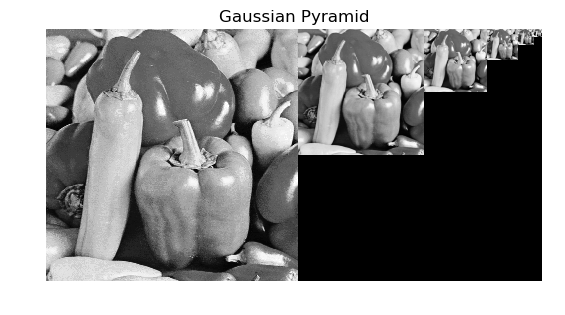

PyObject Text(0.5, 1.0, 'Gaussian Pyramid')

In [4]:
# parameters
fsize = [5 5]
sigma = 1.4
nlevels = 6

# create gaussian pyramid
G = makegaussianpyramid(im,nlevels,fsize,sigma)

# display gaussianpyramid
displaypyramid(G)
title("Gaussian Pyramid")

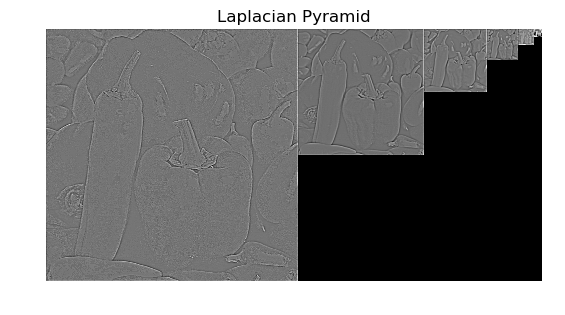

PyObject Text(0.5, 1.0, 'Laplacian Pyramid')

In [5]:
# create laplacian pyramid
L = makelaplacianpyramid(G,nlevels,fsize)

# dispaly laplacian pyramid
displaypyramid(L)
title("Laplacian Pyramid")

In [7]:
# Amplify frequencies of the first two layers of the Laplacian pyramid
function amplifyhighfreq2(L::Array{Array{Float64,2},1})

  # Duplicate (everything is copied recursively)
  A = deepcopy(L)

  # Amplify first two layers
  A[1] *= 1.2
  A[2] *= 1.7

  return A::Array{Array{Float64,2},1}
end


# Reconstruct an image from the Laplacian pyramid
function reconstructlaplacianpyramid(L::Array{Array{Float64,2},1},fsize::Array{Int,2})

  # Start from coarsest resolution
  im = L[end]

  # Upsample subsequent layers
  for i = length(L)-1:-1:1
    im = L[i]+ upsample2(im,fsize)
  end

  # clip image to [0,1]
  # If you did not apply this step: all good
  im = clamp.(im, 0, 1)

  return im::Array{Float64,2}
end

reconstructlaplacianpyramid (generic function with 1 method)

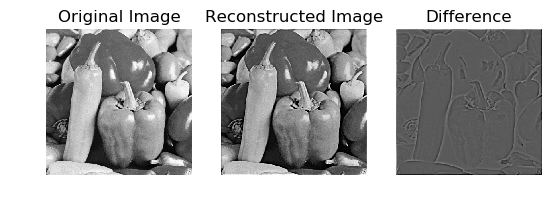

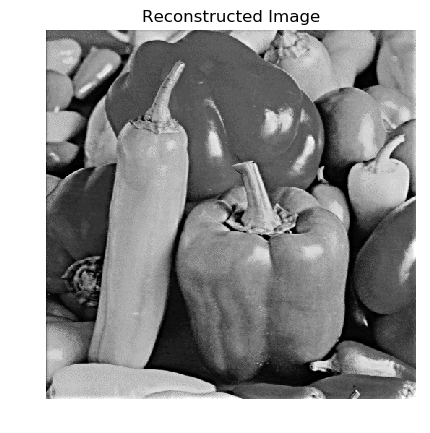

PyObject Text(0.5, 1.0, 'Reconstructed Image')

In [9]:
# amplify finest 2 subands
L_amp = amplifyhighfreq2(L)

# reconstruct image from laplacian pyramid
im_rec = reconstructlaplacianpyramid(L_amp,fsize)

# display original and reconstructed image
figure()
subplot(131)
imshow(im,"gray",interpolation="none")
axis("off")
title("Original Image")
subplot(132)
imshow(im_rec,"gray",interpolation="none")
axis("off")
title("Reconstructed Image")
subplot(133)
imshow(im-im_rec,"gray",interpolation="none")
axis("off")
title("Difference")

figure()
imshow(im_rec,"gray",interpolation="none")
axis("off")
title("Reconstructed Image")